# NYC Delivery Truck Congestion – Step 5: Machine Learning Modeling
*Author: Karan Chauhan*  

This notebook contains the machine learning modeling process to predict high congestion events.

**Objective:** Build a binary classifier to predict `high_congestion` (1) vs `low_congestion` (0).

**Challenge:** The dataset is imbalanced (~75% Low, 25% High). A naive model will achieve ~75% accuracy by simply guessing "Low" every time, but it will have 0% Recall (missing every single traffic jam).

**Solution:** We use `class_weight='balanced'` to force the models to pay attention to the minority class (High Congestion). This typically lowers overall Accuracy but drastically improves Recall and F1 Score, which is critical for an alert system.

**Models Tested:**
1.  **Baseline:** Naive predictor (Always "Low")
2.  **Logistic Regression:** Linear classifier with balanced weights
3.  **Random Forest:** Ensemble method with balanced weights

---

## 1. Import Libraries

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import joblib

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

import warnings
warnings.filterwarnings('ignore')

## 2. Load Data

In [16]:
df = pd.read_csv('../data/modeling_dataset.csv')

print(f"Loaded {len(df):,} observations")
print(f"\nColumns: {list(df.columns)}")
print(f"\nTarget Distribution:")
print(df['high_congestion'].value_counts())
print(f"High Congestion Rate: {df['high_congestion'].mean()*100:.1f}%")

df.head()

Loaded 10,204 observations

Columns: ['grid_id', 'grid_lat', 'grid_lon', 'hour', 'day_of_week', 'complaint_count', 'high_congestion', 'is_weekend', 'is_rush_hour', 'month']

Target Distribution:
high_congestion
0    7626
1    2578
Name: count, dtype: int64
High Congestion Rate: 25.3%


,grid_id,grid_lat,grid_lon,hour,day_of_week,complaint_count,high_congestion,is_weekend,is_rush_hour,month
0,40.69_-74.02,40.69,-74.02,10,0,1,0,0,0,1
1,40.71_-73.98,40.71,-73.98,0,5,1,0,1,0,1
2,40.71_-73.98,40.71,-73.98,1,0,1,0,0,0,1
3,40.71_-73.98,40.71,-73.98,1,1,1,0,0,0,1
4,40.71_-73.98,40.71,-73.98,1,2,1,0,0,0,1


## 3. Train/Test Split
We use the core temporal features identified in Step 4.

In [17]:
feature_cols = ['hour', 'day_of_week', 'is_weekend', 'is_rush_hour', 'month']

X = df[feature_cols]
y = df['high_congestion']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {len(X_train):,} rows")
print(f"Test set: {len(X_test):,} rows")

Training set: 8,163 rows
Test set: 2,041 rows


## 4. Model Benchmarking

### Model 1: Naive Baseline
Predicts 0 (Low Congestion) for everyone. This establishes the "floor" for accuracy but will have 0% Recall.

In [18]:
baseline_pred = np.zeros(len(y_test))

baseline_acc = accuracy_score(y_test, baseline_pred)
baseline_recall = recall_score(y_test, baseline_pred, zero_division=0)

print(f"Baseline Accuracy: {baseline_acc:.3f}")
print(f"Baseline Recall:   {baseline_recall:.3f} (As expected)")

Baseline Accuracy: 0.747
Baseline Recall:   0.000 (As expected)


### Model 2: Logistic Regression (Balanced)
Uses `class_weight='balanced'` to penalize missing high congestion events.

In [19]:
logreg = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

print("Logistic Regression Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_logreg):.3f}")
print(f"Recall:   {recall_score(y_test, y_pred_logreg):.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred_logreg):.3f}")

Logistic Regression Performance:
Accuracy: 0.576
Recall:   0.560
F1 Score: 0.400


### Model 3: Random Forest (Balanced)
A powerful non-linear model, also balanced.

In [20]:
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1, class_weight='balanced')
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.3f}")
print(f"Recall:   {recall_score(y_test, y_pred_rf):.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf):.3f}")

Random Forest Performance:
Accuracy: 0.551
Recall:   0.837
F1 Score: 0.485


## 5. Final Comparison
We prioritize **Recall** (catching congestion) and **F1 Score** (overall balance) over raw Accuracy.

FINAL MODEL EVALUATION
              Model  Accuracy  Precision   Recall  F1 Score
           Baseline  0.747183   0.000000 0.000000  0.000000
Logistic Regression  0.575698   0.311422 0.560078  0.400277
      Random Forest  0.550710   0.341502 0.837209  0.485121


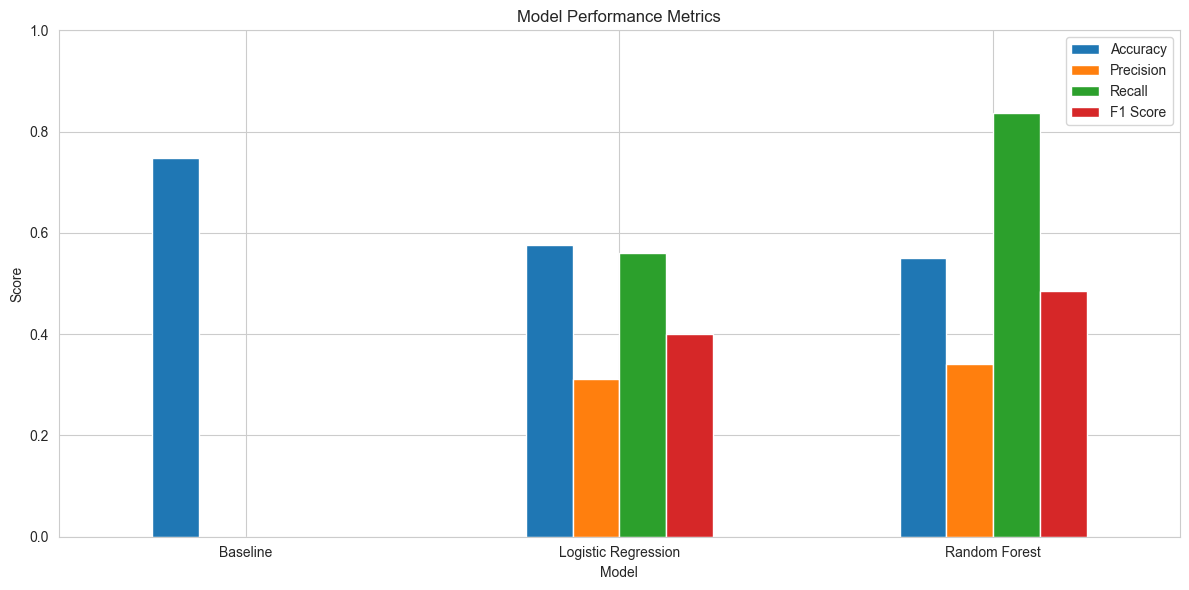

In [21]:
results = pd.DataFrame({
    'Model': ['Baseline', 'Logistic Regression', 'Random Forest'],
    'Accuracy': [baseline_acc, accuracy_score(y_test, y_pred_logreg), accuracy_score(y_test, y_pred_rf)],
    'Precision': [0, precision_score(y_test, y_pred_logreg), precision_score(y_test, y_pred_rf)],
    'Recall': [0, recall_score(y_test, y_pred_logreg), recall_score(y_test, y_pred_rf)],
    'F1 Score': [0, f1_score(y_test, y_pred_logreg), f1_score(y_test, y_pred_rf)]
})

print("="*70)
print("FINAL MODEL EVALUATION")
print("="*70)
print(results.to_string(index=False))

# Visualize
results.set_index('Model').plot(kind='bar', figsize=(12, 6))
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 6. Save Best Model
Random Forest is selected for its superior Recall and F1 Score.

In [22]:
joblib.dump(rf, '../models/random_forest_model.pkl')
joblib.dump(logreg, '../models/logistic_regression_model.pkl')
print("Models saved to ../models/")

Models saved to ../models/
